In [1]:
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import TrainingArguments, Trainer

import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import evaluate

from datasets import Dataset

from datasets import load_dataset

import datasets

from torch import nn

import torch



from rdkit import Chem

from collections import Counter

import math

import itertools

from copy import deepcopy



from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

from scipy.special import softmax

from collections import Counter

import os

# os.environ["WANDB_API_KEY"] = "<API_KEY>" # Optional: Add your Weights & Biases API key

In [2]:
def control_smiles_duplication(random_smiles, duplicate_control=lambda x: 1):

    """

    Returns augmented SMILES with the number of duplicates controlled by the function duplicate_control.



    Taken from https://github.com/volkamerlab/maxsmi/blob/main/maxsmi/utils/utils_smiles.py



    Parameters

    ----------

    random_smiles : list

        A list of random SMILES, can be obtained by `smiles_to_random()`.

    duplicate_control : func, Optional, default: 1

        The number of times a SMILES will be duplicated, as function of the number of times

        it was included in `random_smiles`.

        This number is rounded up to the nearest integer.



    Returns

    -------

    list

        A list of random SMILES with duplicates.



    Notes

    -----

    When `duplicate_control=lambda x: 1`, then the returned list contains only unique SMILES.

    """

    counted_smiles = Counter(random_smiles)

    smiles_duplication = {

        smiles: math.ceil(duplicate_control(counted_smiles[smiles]))

        for smiles in counted_smiles

    }

    return list(

        itertools.chain.from_iterable(

            [[smiles] * smiles_duplication[smiles] for smiles in smiles_duplication]

        )

    )





def smiles_to_random(smiles, int_aug=50):

    """

    Takes a SMILES (not necessarily canonical) and returns `int_aug` random variations of this SMILES.



    Taken from https://github.com/volkamerlab/maxsmi/blob/main/maxsmi/utils/utils_smiles.py



    Parameters

    ----------

    smiles : str

        SMILES string describing a compound.

    int_aug : int, Optional, default: 50

        The number of random SMILES generated.



    Returns

    -------

    list

        A list of `int_aug` random (may not be unique) SMILES or None if the initial SMILES is not valid.

    """



    mol = Chem.MolFromSmiles(smiles)



    if mol is None:

        return None

    else:

        if int_aug > 0:

            return [

                Chem.MolToSmiles(mol, canonical=False, doRandom=True)

                for _ in range(int_aug)

            ]

        elif int_aug == 0:

            return [smiles]

        else:

            raise ValueError("int_aug must be greater or equal to zero.")



def augmentation_without_duplication(smiles, augmentation_number):

    """

    Takes a SMILES and returns a list of unique random SMILES.



    Taken from https://github.com/volkamerlab/maxsmi/blob/main/maxsmi/utils/utils_smiles.py



    Parameters

    ----------

    smiles : str

        SMILES string describing a compound.

    augmentation_number : int

        The integer to generate the number of random SMILES.



    Returns

    -------

    list

        A list of unique random SMILES (no duplicates).

    """

    smiles_list = smiles_to_random(smiles, augmentation_number)

    return control_smiles_duplication(smiles_list, lambda x: 1)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("../dataset/splits/fart_train.csv")
val_df = pd.read_csv("../dataset/splits/fart_val.csv")
test_df = pd.read_csv("../dataset/splits/fart_test.csv")

In [4]:
# Reset index to avoid "__index_level_0__" column
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
augmentation = False # Set to True to augment the dataset

if augmentation:

    # Function to augment dataset based on umami taste

    

    def augment_dataset(dataset, augmentation_numbers,tastes):

        """

        Augments the dataset by generating new SMILES strings for specified tastes.



        Args:

            dataset (Dataset): The original dataset.

            augmentation_numbers (list): Numbers of new SMILES to generate for each taste.

            tastes (list): Taste categories to augment.



        Returns:

            Dataset: Augmented dataset with new SMILES strings.

        """

        augmented_data = []

        for i, taste in enumerate(tastes):

            for entry in dataset:

                if entry["Canonicalized Taste"] == taste:

                    original_smiles = entry["Canonicalized SMILES"]
                    new_smiles_list = augmentation_without_duplication(original_smiles, augmentation_numbers[i])



                    for new_smiles in new_smiles_list:

                        new_entry = deepcopy(entry)

                        new_entry["Canonicalized SMILES"] = new_smiles

                        augmented_data.append(new_entry)

                else:

                    augmented_data.append(entry)



        # Convert augmented_data list to Dataset object

        augmented_dataset = Dataset.from_dict({key: [entry[key] for entry in augmented_data] for key in augmented_data[0]})



        return augmented_dataset



    tastes = ['bitter', 'sour', 'sweet', 'umami', 'undefined']

    augmentation_numbers = [10, 10, 10, 10, 10] # Number of new SMILES to generate for each taste



    train_dataset = augment_dataset(train_dataset, augmentation_numbers, tastes)



    val_dataset = augment_dataset(val_dataset, augmentation_numbers, tastes)



    test_dataset = augment_dataset(test_dataset, augmentation_numbers, tastes)

[09:50:57] WARNING: not removing hydrogen atom without neighbors
[09:50:57] WARNING: not removing hydrogen atom without neighbors
[09:50:58] WARNING: not removing hydrogen atom without neighbors
[09:51:00] WARNING: not removing hydrogen atom without neighbors
[09:51:03] WARNING: not removing hydrogen atom without neighbors


In [7]:
# Load model and tokenizer

# model_checkpoint = "seyonec/SMILES_tokenized_PubChem_shard00_160k"  # Edit this line to use a different pretrained model
model_checkpoint = "DeepChem/ChemBERTa-77M-MTR"  # Edit this line to use a different pretrained model
tokenizer_checkpoint = "seyonec/SMILES_tokenized_PubChem_shard00_160k"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

def tokenize_function(examples):

    return tokenizer(examples["Canonicalized SMILES"], padding="max_length", truncation=True, max_length=512)


train_dataset = train_dataset.map(tokenize_function, batched=True)

val_dataset = val_dataset.map(tokenize_function, batched=True)

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/143887 [00:00<?, ? examples/s]

Map:   0%|          | 0/30940 [00:00<?, ? examples/s]

Map:   0%|          | 0/30890 [00:00<?, ? examples/s]

In [8]:
label_encoder = LabelEncoder()

In [9]:
# Label encoding

encoded_labels = label_encoder.fit_transform(train_dataset['Canonicalized Taste'])

train_dataset = train_dataset.add_column('label', encoded_labels)

encoded_labels = label_encoder.fit_transform(val_dataset['Canonicalized Taste'])

val_dataset = val_dataset.add_column('label', encoded_labels)

encoded_labels = label_encoder.fit_transform(test_dataset['Canonicalized Taste'])

test_dataset = test_dataset.add_column('label', encoded_labels)

In [10]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    """

    Computes accuracy metrics for evaluation predictions.



    Args:

        eval_pred (tuple): A tuple containing logits and labels.



    Returns:

        dict: A dictionary with the accuracy metric.

    """

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [11]:
label_encoder.inverse_transform(range(5))

array(['bitter', 'sour', 'sweet', 'umami', 'undefined'], dtype='<U9')

In [ ]:
num_labels = 5
# model_checkpoint = "seyonec/SMILES_tokenized_PubChem_shard00_160k" # Edit this line to use a different pretrained model
model_checkpoint = "./chemberta/100k_test/final" # Edit this line to use a different pretrained model
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

training_args = TrainingArguments(

    run_name = "<RUN_NAME>", # Optional: Add a name for the run to identify it in Weights & Biases

    output_dir="./results",

    num_train_epochs=2,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    weight_decay=0.01,

    eval_strategy="steps",

    logging_dir="./logs",

    save_strategy="steps",

    load_best_model_at_end=True,

    save_total_limit=5,

)



# Initialize the Trainer

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=train_dataset,

    eval_dataset=val_dataset,
    
    compute_metrics=compute_metrics,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./chemberta/100k_test/final and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train() # Train model

/Users/terrykim/Desktop/mit/6.4610/project/model/fart/venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
results = trainer.evaluate(eval_dataset=val_dataset)    # Evaluate the model after training with best eval score

print(results)

/Users/terrykim/Desktop/mit/6.4610/project/model/fart/venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3310946822166443, 'eval_accuracy': 0.8819875776397516, 'eval_runtime': 37.736, 'eval_samples_per_second': 59.731, 'eval_steps_per_second': 3.736, 'epoch': 2.0}


In [ ]:
predictions = trainer.predict(test_dataset)             # Predict on test set

/Users/terrykim/Desktop/mit/6.4610/project/model/fart/venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


# Evalutation

In [ ]:
probs = softmax(predictions.predictions, axis=1)
pred_labels = np.argmax(probs, axis=1)
true_labels = predictions.label_ids

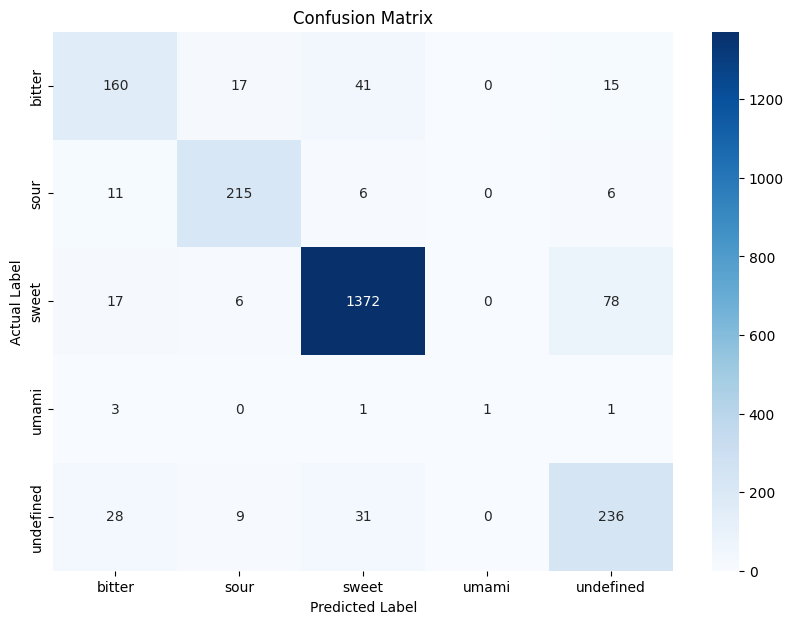

In [ ]:
# Create confusion matrix

conf_matrix = confusion_matrix(true_labels, pred_labels)

label_names = label_encoder.inverse_transform(range(5))

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)

plt.title('Confusion Matrix')

plt.ylabel('Actual Label')

plt.xlabel('Predicted Label')

plt.show()


In [ ]:
# Calculate accuracy

accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")



# Calculate precision, recall, and F1 score for each class

precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels)



# Optionally, if you want to calculate the weighted scores as well

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

print(f"Weighted Precision: {precision_weighted:.4f}")

print(f"Weighted Recall: {recall_weighted:.4f}")

print(f"Weighted F1 Score: {f1_weighted:.4f}")

class_names = label_encoder.classes_

for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):

    print(f"Class {class_names[i]}:")

    print(f"  Precision: {p:.4f}")

    print(f"  Recall: {r:.4f}")

    print(f"  F1 Score: {f:.4f}")

    print(f"  Support: {s}")

Accuracy: 0.8802
Weighted Precision: 0.8498
Weighted Recall: 0.6929
Weighted F1 Score: 0.7112
Class bitter:
  Precision: 0.7306
  Recall: 0.6867
  F1 Score: 0.7080
  Support: 233
Class sour:
  Precision: 0.8704
  Recall: 0.9034
  F1 Score: 0.8866
  Support: 238
Class sweet:
  Precision: 0.9456
  Recall: 0.9314
  F1 Score: 0.9384
  Support: 1473
Class umami:
  Precision: 1.0000
  Recall: 0.1667
  F1 Score: 0.2857
  Support: 6
Class undefined:
  Precision: 0.7024
  Recall: 0.7763
  F1 Score: 0.7375
  Support: 304


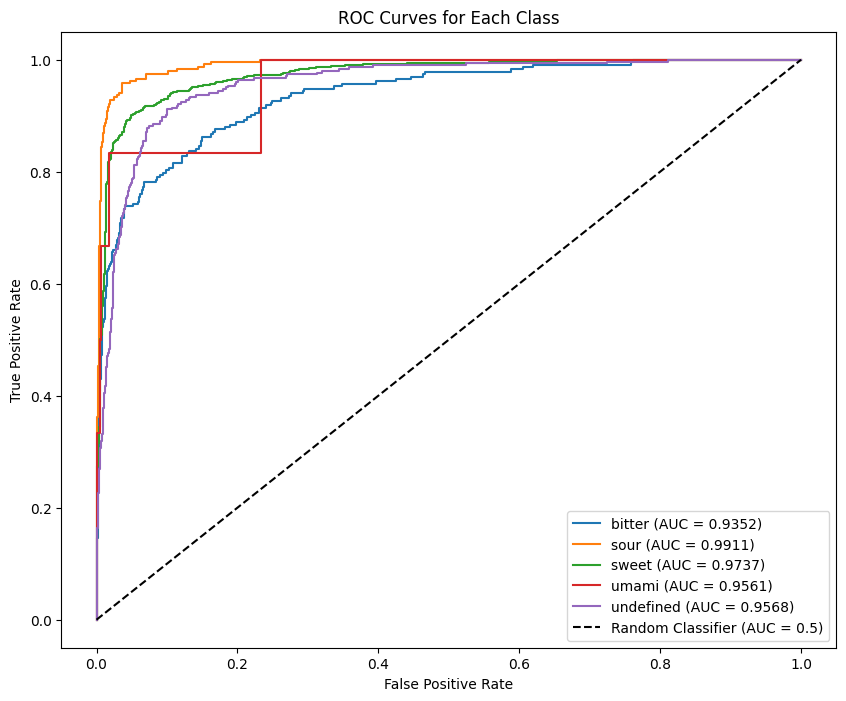

In [ ]:
# Plot ROC curves for each class

from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

num_classes = probs.shape[1]

# Binarize the true labels
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

class_labels = label_encoder.inverse_transform(range(5))

plt.figure(figsize=(10, 8))
auc_scores = []
for i in range(num_classes):
    if np.sum(true_labels_bin[:, i]) > 0:  # Check if the class is in y_true
        auc = roc_auc_score(true_labels_bin[:, i], probs[:, i])
        auc_scores.append(auc)
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc:.4f})")
    else:
        print(f"{class_labels[i]} not present in true_labels.")

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.savefig('ROC.pdf')

In [ ]:
# Ensemble voting (Confidence)
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.preprocessing import label_binarize

df = pd.DataFrame({
    'Standardized SMILES': test_dataset['Standardized SMILES'],
    'label': test_dataset['label'],
    'pred_probs': list(softmax(predictions.predictions, axis=1))
})

df['pred_labels'] = np.argmax(df['pred_probs'].tolist(), axis=1)

# Majority voting for each molecule (Parent_SMILES group)
grouped = df.groupby('Standardized SMILES').agg({
    'pred_labels': lambda x: x.value_counts().idxmax() if x.value_counts().iloc[0] >= 10 else np.nan,
    'label': 'first' 
}).dropna().reset_index()

num_classes = predictions.predictions.shape[1]
true_labels_bin = label_binarize(grouped['label'], classes=np.arange(num_classes))
pred_probs = np.array([np.mean(df.loc[df['Standardized SMILES'] == smile, 'pred_probs'], axis=0) 
                       for smile in grouped['Standardized SMILES']])

plt.figure(figsize=(10, 8))
auc_scores = []
for i in range(num_classes):
    if np.sum(true_labels_bin[:, i]) > 0:  # Check if class is present in true labels
        auc = roc_auc_score(true_labels_bin[:, i], pred_probs[:, i])
        auc_scores.append(auc)
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc:.4f})")
    else:
        print(f"{class_labels[i]} not present in true labels.")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class (Ensemble Voting)")
plt.legend(loc="lower right")
plt.savefig('ROC_voted.pdf')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Filtered true and predicted labels from the ensemble voting process
true_labels_voted = grouped['label'].values
pred_labels_voted = grouped['pred_labels'].values

# Calculate accuracy
accuracy = accuracy_score(true_labels_voted, pred_labels_voted)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, support = precision_recall_fscore_support(true_labels_voted, pred_labels_voted, labels=np.arange(num_classes))

# Optionally, calculate the weighted scores as well
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    true_labels_voted, pred_labels_voted, average='macro', labels=np.arange(num_classes))
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")

# Print scores for each class
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
    print(f"Class {class_labels[i]}:")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall: {r:.4f}")
    print(f"  F1 Score: {f:.4f}")
    print(f"  Support: {s}")


# Additional Comparison to Binary Classifiers

In [ ]:
Confidence = True # Set to True to use confidence-based ensemble voting

if Confidence:
    assert augmented == True # Confidence-based ensemble voting requires augmented dataset
    df = pd.DataFrame({
        'Standardized SMILES': test_dataset['Standardized SMILES'],
        'label': test_dataset['label'],
        'pred_probs': list(softmax(predictions.predictions, axis=1))
    })
    
    # Get the predicted labels
    df['pred_labels'] = np.argmax(df['pred_probs'].tolist(), axis=1)
    
    grouped = df.groupby('Standardized SMILES').agg({
        'pred_labels': lambda x: x.value_counts().idxmax() if x.value_counts().iloc[0] >= 10 else np.nan,
        'label': 'first',  # Assume all SMILES for a molecule have the same true label
        'pred_probs': lambda x: np.mean(np.vstack(x), axis=0)  # Aggregate probabilities
    }).dropna().reset_index()
    
    grouped['final_pred_label'] = grouped['pred_probs'].apply(lambda x: np.argmax(x))
    
    probs = grouped["pred_probs"].tolist()
    pred_labels = grouped["pred_labels"].tolist()
    true_labels = grouped["label"].tolist()

In [ ]:
positive_class = "bitter" # Edit this line to use a different class
positive_class = label_encoder.transform([positive_class])[0]

# Binarize the labels
true_binary = [1 if label == positive_class else 0 for label in true_labels]
pred_binary = [1 if label == positive_class else 0 for label in pred_labels]

# Compute metrics
accuracy = accuracy_score(true_binary, pred_binary)
report = classification_report(true_binary, pred_binary, target_names=['non-' + positive_class, positive_class], output_dict=True)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
from sklearn.metrics import roc_auc_score

positive_class = "bitter" # Edit this line to use a different class
index = label_encoder.transform([positive_class])[0]

# Extract sweet probabilities
probs = [prob[index] for prob in probs]

# Binarize the true labels
positive_class = index
true_binary = [1 if label == positive_class else 0 for label in true_labels]

# Compute AUROC
auroc = roc_auc_score(true_binary, probs)

# Output the result
print(f"Binarized AUROC for {positive_class}/non-{positive_class} classification: {auroc}")